In [1]:
%load_ext autoreload
%autoreload 2

# change directory to repo root, and verify
%cd '../'
!pwd

/cephyr/users/markpett/Alvis/satellite_poverty_prediction
/cephyr/users/markpett/Alvis/satellite_poverty_prediction


In [48]:
import matplotlib.pyplot as plt
from utils.plot import scatter_preds, to_gif
from utils.analysis import evaluate_df
from utils.names import rename_names, iso_a3_codes

In [49]:
from collections import defaultdict
import itertools
import pickle
import os
import sys
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from matplotlib.pyplot import figure
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [50]:
data_dir = '/cephyr/NOBACKUP/groups/globalpoverty1/data/'
MIN_IWI = 0
MAX_IWI = 100
MODEL_NAMES = ['resnet', 'bidirectional_resnet_lstm', 'bidirectional_resnet_lstm_10', 'knn']

df = pd.read_csv(os.path.join(data_dir, 'dhs_clusters.csv'), float_precision='high', index_col=False)

df['name'] = df['country'].apply(lambda x: rename_names[x])
df['iso_a3'] = df['country'].apply(lambda x: iso_a3_codes[x])
df['i'] = df['year'].apply(lambda x: (x-1990) // 3)

In [51]:
for fold_config in ['incountry', 'ooc', 'oots']:
    fold_results = []
    for fold in 'ABCDE':
        results_path = os.path.join(data_dir, 'hists', fold_config, fold, 'knn_preds.csv')
        fold_results.append(pd.read_csv(results_path, float_precision='high', index_col='Unnamed: 0'))
    res = pd.concat(fold_results).sort_index()
    store_path = os.path.join(data_dir, 'results', fold_config, 'knn.csv')
    res.to_csv(store_path)

In [52]:
results_dict = {}
for fold_config in ['incountry', 'ooc', 'oots']:
    results_dict[fold_config] = {}
    for model_name in MODEL_NAMES:
        results_path = os.path.join(data_dir, 'results', fold_config, model_name + '.csv')
        results_df = pd.read_csv(results_path, float_precision='high', index_col=False)
        results_df = results_df.set_index('Unnamed: 0')
        # Rescale prediction values
        results_df.loc[:, results_df.columns != 'fold'] = (MAX_IWI - MIN_IWI) * results_df.loc[:, results_df.columns != 'fold'] + MIN_IWI
        results_df = df.merge(results_df, left_index=True, right_index=True)
        results_df['error'] = results_df.apply(lambda x: abs(x['iwi'] - x['y_i']), axis=1)
        results_dict[fold_config][model_name] = results_df

## Scatter per model

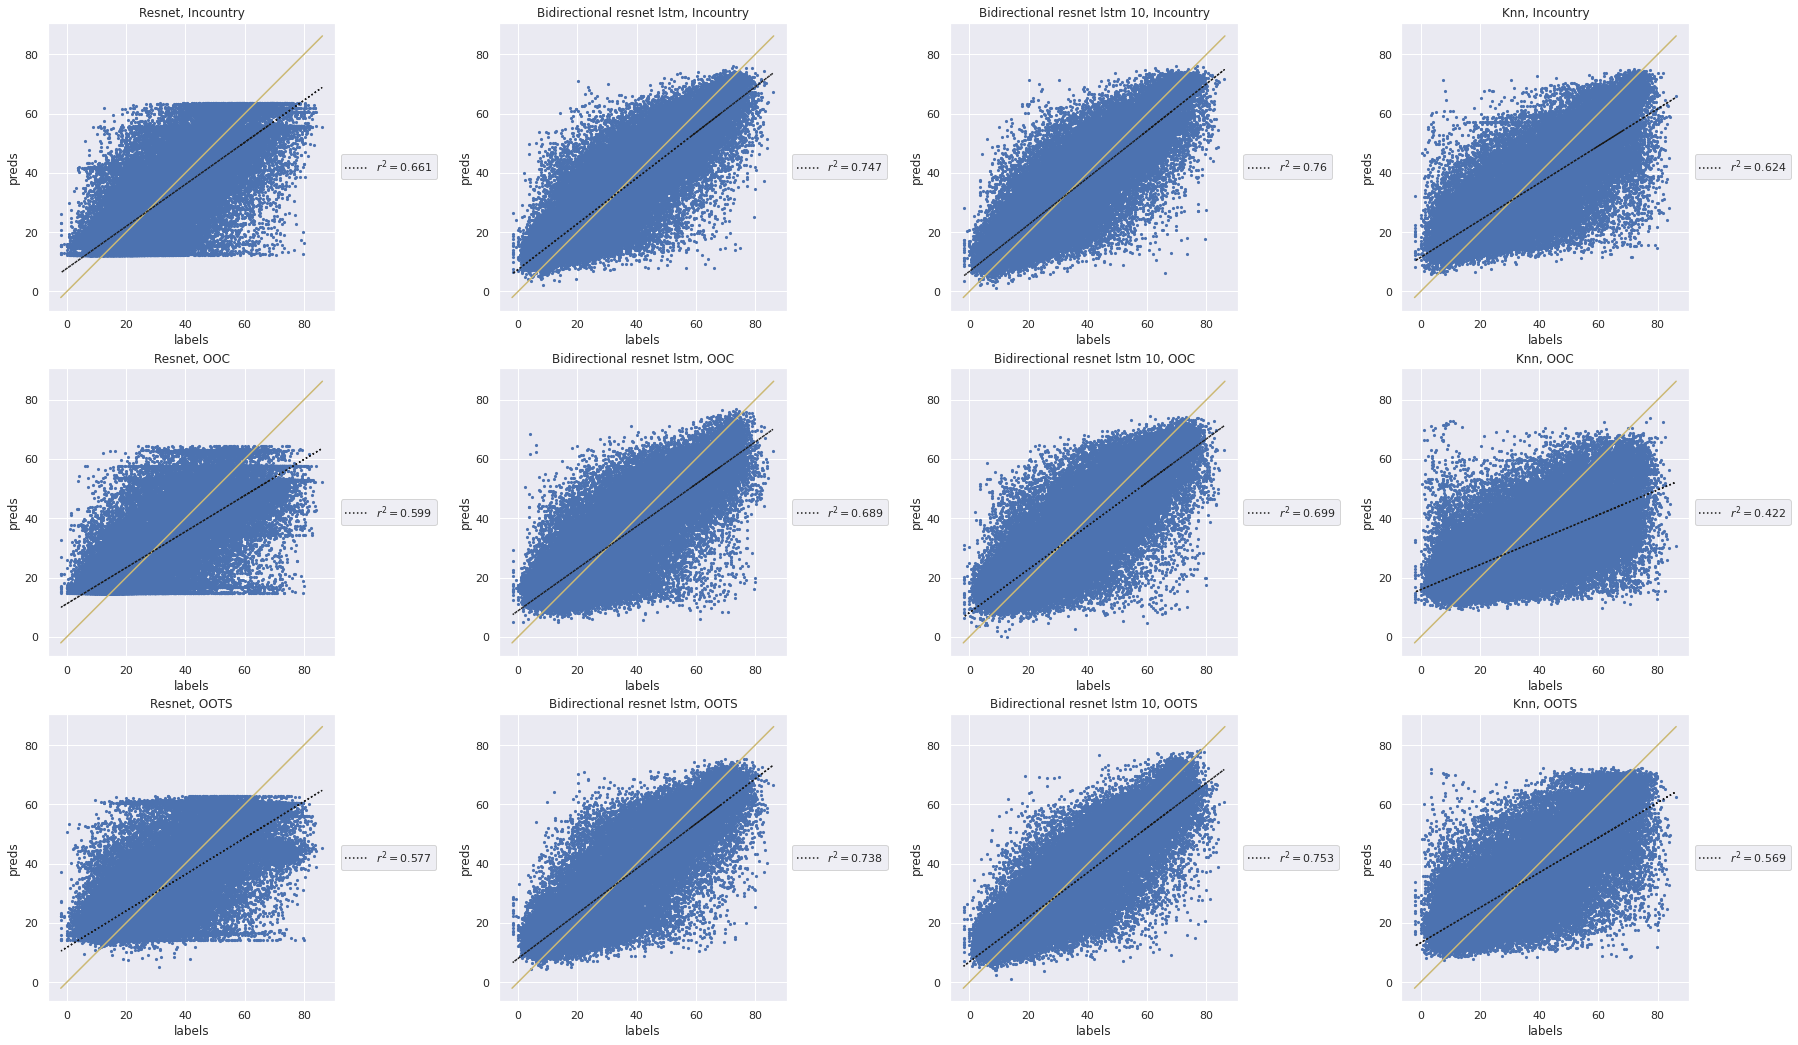

In [53]:
fig, axs = plt.subplots(3, 4, figsize=(31, 18))

for i, fold_config in enumerate(results_dict):
    for j, model_name in enumerate(results_dict[fold_config]):
        results_df = results_dict[fold_config][model_name]
        labels, preds = results_df['iwi'], results_df['y_i']
        fold_config_name = 'Incountry' if i == 0 else fold_config.upper()
        model_name = model_name.replace('_', ' ').capitalize()
        title = model_name + ', ' + fold_config_name
        scatter_preds(labels, preds, by_name=None, by_col=None, ax=axs[i, j],
                  title=title, figsize=(5, 5))

In [55]:
stats_dict = {}

for fold_config in results_dict:
    fold_config_df = df.copy()

    model_pred_cols = []
    for model in results_dict[fold_config]:
        model_pred_col = model
        model_pred_cols.append(model_pred_col)
        model_df = results_dict[fold_config][model]
        fold_config_df[model_pred_col] = model_df['y_i']
        fold_config_df[model_pred_col + '_error'] = model_df['iwi'] - model_df['y_i']

    fold_config_df = fold_config_df.dropna()
    fold_config_df['fold'] = results_dict[fold_config][model]['fold']
    
    stats_dict[fold_config] = fold_config_df

In [43]:
u_r2 = scipy.stats.pearsonr(u_data['iwi'], u_data['y_i'])[0] ** 2

,country,survey_start_year,year,lat,lon,GID_1,GID_2,households,rural,iwi,name,iso_a3,i,resnet,resnet_error,bidirectional_resnet_lstm,bidirectional_resnet_lstm_error,bidirectional_resnet_lstm_10,bidirectional_resnet_lstm_10_error,fold
0,angola,2006,2006,-12.169283,13.859255,AGO.2,AGO.2.9,20,0,68.096300,Angola,AGO,5,12.194824,55.901476,14.299317,53.796983,12.841797,55.254503,B
1,angola,2006,2006,-12.361700,14.778201,AGO.2,AGO.2.2,19,1,10.609053,Angola,AGO,5,29.443360,-18.834307,30.463868,-19.854815,27.392578,-16.783525,A
2,angola,2006,2006,-10.827451,14.342114,AGO.7,AGO.7.1,25,1,29.973928,Angola,AGO,5,12.561035,17.412893,18.623047,11.350881,15.649414,14.324514,B
3,angola,2006,2006,-9.991311,14.898295,AGO.7,AGO.7.5,1,1,7.704135,Angola,AGO,5,15.649414,-7.945279,28.710938,-21.006803,15.588379,-7.884244,A
4,angola,2006,2006,-11.518893,14.750437,AGO.7,AGO.7.10,24,1,13.371826,Angola,AGO,5,12.585449,0.786377,10.401611,2.970215,10.754395,2.617431,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57190,zimbabwe,2015,2015,-20.911177,30.008579,ZWE.10,ZWE.10.6,28,1,27.791567,Zimbabwe,ZWE,8,15.954590,11.836977,20.776367,7.015200,15.112305,12.679262,E
57191,zimbabwe,2015,2015,-20.402214,29.860028,ZWE.10,ZWE.10.8,28,1,36.929878,Zimbabwe,ZWE,8,22.363281,14.566597,20.428467,16.501411,28.002930,8.926948,A
57192,zimbabwe,2015,2015,-20.724753,30.172833,ZWE.10,ZWE.10.6,27,1,24.406326,Zimbabwe,ZWE,8,15.966797,8.439529,17.535400,6.870926,22.290039,2.116287,E
57193,zimbabwe,2015,2015,-19.453466,29.820084,ZWE.10,ZWE.10.4,28,0,59.887344,Zimbabwe,ZWE,8,48.583984,11.303360,53.466797,6.420547,54.687500,5.199844,D


## Model performance per fold

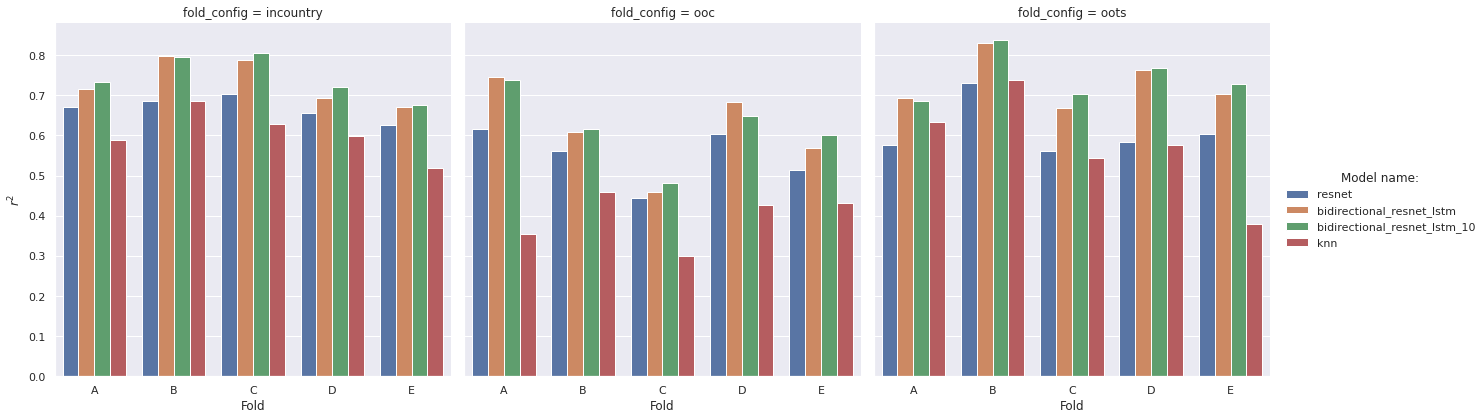

In [56]:
fold_stats_dfs = []

for fold_config in stats_dict:
    fold_config_df = stats_dict[fold_config]
    per_fold_df = fold_config_df.groupby('fold').apply(evaluate_df, cols=model_pred_cols, labels_col='iwi')
    per_fold_df = per_fold_df.reset_index()
    per_fold_df = per_fold_df.rename(columns={'level_1': 'model_name'})
    per_fold_df['fold_config'] = fold_config
    fold_stats_dfs.append(per_fold_df)

fold_stats_df = pd.concat(fold_stats_dfs)

sns.set_theme(style='darkgrid')
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=fold_stats_df, kind='bar',
    x='fold', y='r2', col='fold_config', hue='model_name', height=6
)

g.set_axis_labels('Fold', '$r^2$')
g.legend.set_title('Model name:')

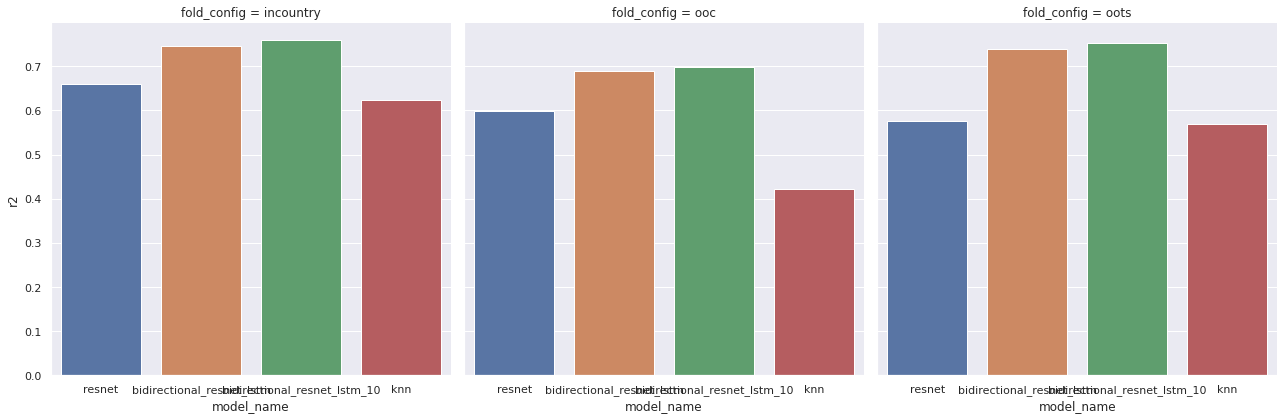

In [67]:
fold_stats_dfs = []

for fold_config in stats_dict:
    fold_config_df = stats_dict[fold_config]
    per_fold_config_df = evaluate_df(fold_config_df, cols=model_pred_cols, labels_col='iwi')
    per_fold_config_df = per_fold_config_df.reset_index()
    per_fold_config_df = per_fold_config_df.rename(columns={'index': 'model_name'})
    per_fold_config_df['fold_config'] = fold_config
    fold_stats_dfs.append(per_fold_config_df)

fold_stats_df = pd.concat(fold_stats_dfs)

sns.set_theme(style='darkgrid')
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=fold_stats_df, kind='bar',
    x='model_name', y='r2', col='fold_config', height=6
)

#g.set_axis_labels('Fold', '$r^2$')
#g.legend.set_title('Model name:')

In [77]:
fold_stats_df = fold_stats_df.replace('resnet', 'Resnet')
fold_stats_df = fold_stats_df.replace('bidirectional_resnet_lstm', 'Five frame')
fold_stats_df = fold_stats_df.replace('bidirectional_resnet_lstm_10', 'Ten frame')
fold_stats_df = fold_stats_df.replace('knn', 'KNN baseline')
fold_stats_df = fold_stats_df.replace('incountry', 'OOA')
fold_stats_df = fold_stats_df.replace('ooc', 'OOC')
fold_stats_df = fold_stats_df.replace('oots', 'OOTS')
fold_stats_df = fold_stats_df.rename(columns={'model_name': 'Model name', 'fold_config': 'Fold configuration'})
fold_stats_df

,Model name,r2,R2,mse,rmse,rank,Fold configuration
0,Resnet,0.660519,0.650536,131.642030,8.632048,0.769107,OOA
1,Five frame,0.746634,0.745903,95.717544,7.304565,0.833456,OOA
2,Ten frame,0.760483,0.759222,90.700279,7.081731,0.846913,OOA
3,KNN baseline,0.624067,0.623451,141.844920,8.865716,0.760999,OOA
0,Resnet,0.598551,0.592984,153.981785,9.394429,0.742680,OOC
1,Five frame,0.689203,0.687893,118.076093,8.216749,0.782878,OOC
2,Ten frame,0.699013,0.696793,114.709054,8.043694,0.796584,OOC
3,KNN baseline,0.421577,0.402031,226.222950,11.304622,0.638515,OOC
0,Resnet,0.576693,0.573060,161.519554,9.558405,0.733070,OOTS
1,Five frame,0.738241,0.737632,99.258811,7.469546,0.819290,OOTS


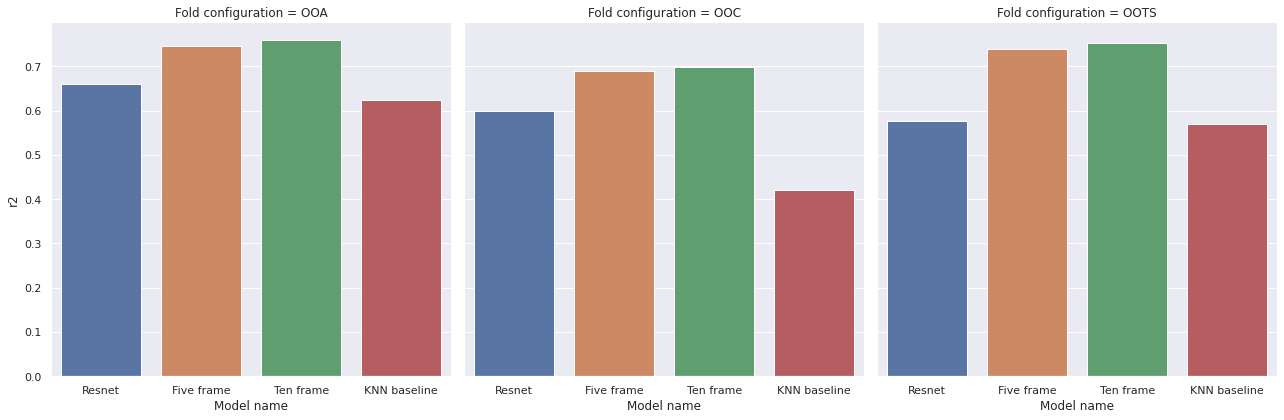

In [79]:
g = sns.catplot(
    data=fold_stats_df, kind='bar',
    x='Model name', y='r2', col='Fold configuration', height=6
)